<a href="https://colab.research.google.com/github/manishaachary13/Space-Launch-Mission/blob/main/mission%20launch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✈️ Project Title:  **Big Data Analytics of Global Space Launch Missions**

# **🧩 Problem Statement:**

With the rise of both government and private space agencies, the number of satellite and exploratory missions has increased rapidly. However, delays, failures, and cost overruns still pose a serious challenge. This project aims to use Big Data tools (specifically PySpark) to analyze historical space launch data, uncover patterns in successful/failed missions, and predict mission outcomes.

This project aims to utilize **Big Data analytics using PySpark** to process and analyze historical global space launch mission data. The goals are to:
* Identify patterns and trends in space launch activity over time.
* Analyze mission success/failure based on organization, rocket status, launch site, or launch type.
* Explore cost drivers in space missions and the relationship between cost and success.
* Predict mission outcomes (success/failure) using classification models.

## 🛰️ Key Features in the Dataset:


Organisation: Agency or private company (e.g., SpaceX, ISRO, NASA, Roscosmos)

Location: Launch site

Date: Mission launch date

Detail: Description of the mission

Rocket_Status: Operational status of the rocket

Price: Launch cost (in million USD)

Mission_Status: Outcome of the mission (e.g., Success, Failure, Partial Failure)

# **Load the Dataset and Data Preprocessing**

#### 📦 1. Install and Configure PySpark

In [165]:
# 1. Install Java and PySpark
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install -q pyspark findspark

# 2. Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

# 3. Initialize Findspark
import findspark
findspark.init()

# 4. Start Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SpaceLaunchBigData") \
    .getOrCreate()

print("✅ Spark Session Created Successfully")



✅ Spark Session Created Successfully


#### Load CSV (from Github)

In [166]:
!wget -O mission_launches.csv "https://raw.githubusercontent.com/manishaachary13/Space-Launch-Mission/refs/heads/main/mission_launches.csv"


--2025-04-15 12:35:41--  https://raw.githubusercontent.com/manishaachary13/Space-Launch-Mission/refs/heads/main/mission_launches.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 632009 (617K) [text/plain]
Saving to: ‘mission_launches.csv’

mission_launches.cs 100%[===================>] 617.20K  --.-KB/s    in 0.05s   

2025-04-15 12:35:42 (11.4 MB/s) - ‘mission_launches.csv’ saved [632009/632009]



In [167]:
df = spark.read.csv("mission_launches.csv", header=True, inferSchema=True)

#### Basic Informations

In [168]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Unnamed: 0: integer (nullable = true)
 |-- Organisation: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Detail: string (nullable = true)
 |-- Rocket_Status: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Mission_Status: string (nullable = true)



In [169]:
df.show(5, truncate=False)

+---+----------+------------+---------------------------------------------------------+--------------------------+--------------------------------------------+-------------+-----+--------------+
|_c0|Unnamed: 0|Organisation|Location                                                 |Date                      |Detail                                      |Rocket_Status|Price|Mission_Status|
+---+----------+------------+---------------------------------------------------------+--------------------------+--------------------------------------------+-------------+-----+--------------+
|0  |0         |SpaceX      |LC-39A, Kennedy Space Center, Florida, USA               |Fri Aug 07, 2020 05:12 UTC|Falcon 9 Block 5 | Starlink V1 L9 & BlackSky|StatusActive |50.0 |Success       |
|1  |1         |CASC        |Site 9401 (SLS-2), Jiuquan Satellite Launch Center, China|Thu Aug 06, 2020 04:01 UTC|Long March 2D | Gaofen-9 04 & Q-SAT         |StatusActive |29.75|Success       |
|2  |2         |SpaceX   

In [170]:
print("Number of Rows:", df.count())
print("Number of Columns:", len(df.columns))

Number of Rows: 4324
Number of Columns: 9


#### Describe numerical columns

In [171]:
df.describe().show()

+-------+------------------+------------------+------------+--------------------+--------------------+--------------------+-------------+------------------+--------------+
|summary|               _c0|        Unnamed: 0|Organisation|            Location|                Date|              Detail|Rocket_Status|             Price|Mission_Status|
+-------+------------------+------------------+------------+--------------------+--------------------+--------------------+-------------+------------------+--------------+
|  count|              4324|              4324|        4324|                4324|                4324|                4324|         4324|               964|          4324|
|   mean|            2161.5|            2161.5|        NULL|                NULL|                NULL|                NULL|         NULL|129.79523709167552|          NULL|
| stddev|1248.3756112110916|1248.3756112110916|        NULL|                NULL|                NULL|                NULL|         NULL| 14

#### Checking for Missing Values(Column-wise)

In [172]:
from pyspark.sql.functions import col, when, count, isnan

df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()

+---+----------+------------+--------+----+------+-------------+-----+--------------+
|_c0|Unnamed: 0|Organisation|Location|Date|Detail|Rocket_Status|Price|Mission_Status|
+---+----------+------------+--------+----+------+-------------+-----+--------------+
|  0|         0|           0|       0|   0|     0|            0| 3360|             0|
+---+----------+------------+--------+----+------+-------------+-----+--------------+



#### Unique Values per column

In [173]:
for col_name in df.columns:
    df.select(col_name).distinct().count()
    print(f"Unique values in '{col_name}':", df.select(col_name).distinct().count())

Unique values in '_c0': 4324
Unique values in 'Unnamed: 0': 4324
Unique values in 'Organisation': 56
Unique values in 'Location': 137
Unique values in 'Date': 4319
Unique values in 'Detail': 4278
Unique values in 'Rocket_Status': 2
Unique values in 'Price': 57
Unique values in 'Mission_Status': 4


#### Column names and Their Datatypes

In [174]:
[(name, dtype) for name, dtype in df.dtypes]

[('_c0', 'int'),
 ('Unnamed: 0', 'int'),
 ('Organisation', 'string'),
 ('Location', 'string'),
 ('Date', 'string'),
 ('Detail', 'string'),
 ('Rocket_Status', 'string'),
 ('Price', 'string'),
 ('Mission_Status', 'string')]

#### Frequecy of each mission status

In [175]:
df.groupBy("Mission_Status").count().orderBy("count", ascending=False).show()

+-----------------+-----+
|   Mission_Status|count|
+-----------------+-----+
|          Success| 3879|
|          Failure|  339|
|  Partial Failure|  102|
|Prelaunch Failure|    4|
+-----------------+-----+



#### Frequency of each rocket status

In [176]:
df.groupBy("Rocket_Status").count().orderBy("count", ascending=False).show()

+-------------+-----+
|Rocket_Status|count|
+-------------+-----+
|StatusRetired| 3534|
| StatusActive|  790|
+-------------+-----+



#### Check for blank strings

In [177]:
from pyspark.sql.functions import length, trim

df.select([count(when(trim(col(c)) == "", c)).alias(c) for c in df.columns]).show()

+---+----------+------------+--------+----+------+-------------+-----+--------------+
|_c0|Unnamed: 0|Organisation|Location|Date|Detail|Rocket_Status|Price|Mission_Status|
+---+----------+------------+--------+----+------+-------------+-----+--------------+
|  0|         0|           0|       0|   0|     0|            0|    0|             0|
+---+----------+------------+--------+----+------+-------------+-----+--------------+



####  Check for Duplicate rows

In [178]:
duplicates = df.groupBy(df.columns).count().filter("count > 1")
print("Number of duplicate rows:", duplicates.count())

Number of duplicate rows: 0


#### Length of tect columns

In [179]:
from pyspark.sql.functions import length

df.select("Organisation", length(col("Organisation")).alias("Length")).show(5)

+------------+------+
|Organisation|Length|
+------------+------+
|      SpaceX|     6|
|        CASC|     4|
|      SpaceX|     6|
|   Roscosmos|     9|
|         ULA|     3|
+------------+------+
only showing top 5 rows



#### Distribution of data in numerial columns

In [180]:
df.select("Price").describe().show()

+-------+------------------+
|summary|             Price|
+-------+------------------+
|  count|               964|
|   mean|129.79523709167552|
| stddev| 143.2203233531596|
|    min|           1,160.0|
|    max|              90.0|
+-------+------------------+



#### Check for mixed data types

In [181]:
df.select("Price").distinct().orderBy("Price").show(20)

+-------+
|  Price|
+-------+
|   NULL|
|1,160.0|
|  109.0|
|  112.5|
|  115.0|
|   12.0|
|  120.0|
|  123.0|
|  130.0|
|  133.0|
|  135.0|
|  136.6|
|  140.0|
|  145.0|
|   15.0|
|  153.0|
|  164.0|
|  190.0|
|   20.0|
|  20.14|
+-------+
only showing top 20 rows



####Sample Date Checks (Earliest & Latest)

In [182]:
df.select("Date").orderBy("Date").show(5)  # Earliest
df.select("Date").orderBy("Date", ascending=False).show(5)  # Latest

+--------------------+
|                Date|
+--------------------+
|Fri Apr 01, 1960 ...|
|Fri Apr 02, 1971 ...|
|Fri Apr 02, 1999 ...|
|Fri Apr 02, 2010 ...|
|Fri Apr 03, 1970 ...|
+--------------------+
only showing top 5 rows

+--------------------+
|                Date|
+--------------------+
|Wed Sep 30, 2015 ...|
|Wed Sep 30, 1981 ...|
|Wed Sep 29, 1976 ...|
|Wed Sep 29, 1971 ...|
|Wed Sep 28, 1983 ...|
+--------------------+
only showing top 5 rows



####Top Launching Organizations

In [183]:
df.groupBy("Organisation").count().orderBy("count", ascending=False).show(10)

+----------------+-----+
|    Organisation|count|
+----------------+-----+
|       RVSN USSR| 1777|
|     Arianespace|  279|
|            CASC|  251|
|General Dynamics|  251|
|            NASA|  203|
|          VKS RF|  201|
|    US Air Force|  161|
|             ULA|  140|
|          Boeing|  136|
| Martin Marietta|  114|
+----------------+-----+
only showing top 10 rows



#### Detecting columns with constant or low variance values

In [184]:
for c in df.columns:
    unique_count = df.select(c).distinct().count()
    if unique_count <= 2:
        print(f"Column '{c}' has low variance: only {unique_count} unique values")

Column 'Rocket_Status' has low variance: only 2 unique values


#### Null Value Matrix for visual inspection

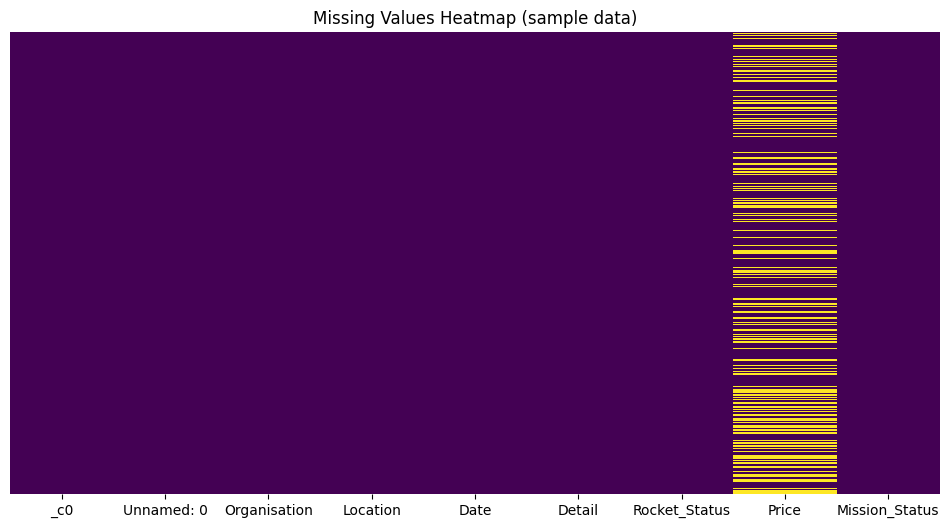

In [185]:
sample_df = df.limit(1000).toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(sample_df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Values Heatmap (sample data)")
plt.show()

#### View Potential Typos in 'Organisation

In [186]:
df.select("Organisation").distinct().orderBy("Organisation").show(50, truncate=False)

+----------------+
|Organisation    |
+----------------+
|AEB             |
|AMBA            |
|ASI             |
|Arianespace     |
|Arm??e de l'Air |
|Blue Origin     |
|Boeing          |
|CASC            |
|CASIC           |
|CECLES          |
|CNES            |
|Douglas         |
|EER             |
|ESA             |
|Eurockot        |
|ExPace          |
|Exos            |
|General Dynamics|
|IAI             |
|ILS             |
|IRGC            |
|ISA             |
|ISAS            |
|ISRO            |
|JAXA            |
|KARI            |
|KCST            |
|Khrunichev      |
|Kosmotras       |
|Land Launch     |
|Landspace       |
|Lockheed        |
|MHI             |
|MITT            |
|Martin Marietta |
|NASA            |
|Northrop        |
|OKB-586         |
|OneSpace        |
|RAE             |
|RVSN USSR       |
|Rocket Lab      |
|Roscosmos       |
|SRC             |
|Sandia          |
|Sea Launch      |
|SpaceX          |
|Starsem         |
|ULA             |
|US Air Forc

### 🔍 **What We Have Done So Far**

1. **Created Spark Session**  
   ✔️ Successfully started Spark in Colab.

2. **Loaded the Dataset**  
   ✔️ Read CSV file using `spark.read.csv()` with headers and schema detection.

3. **Checked Dataset Info**
   - Viewed schema with `printSchema()`
   - Previewed rows with `.show()`
   - Counted rows and columns

4. **Described Numerical Columns**
   ✔️ Used `.describe()` to get count, mean, min, max, etc.

5. **Checked Missing Values**
   - Found `null`, `NaN`, and **blank values** in some columns.

6. **Checked Unique Values**
   ✔️ Counted unique entries in each column.

7. **Top Categories**
   - Most frequent **Organisations**
   - Most used **Locations**
   - Count of each **Mission_Status** and **Rocket_Status**

8. **Low Variance Columns**
   ✔️ Found columns with only 1–2 unique values (less useful for analysis).

9. **Date Range Check**
   ✔️ Found the earliest and latest mission dates.

10. **Duplicate Rows**
   ✔️ Checked for repeated rows in the dataset.

11. **Potential Typos**
   ✔️ Reviewed all unique values in `Organisation` to spot inconsistent names.


# **Data Cleaning or Data Wrangling**

Convert Price column dtype into float

In [187]:
from pyspark.sql.functions import regexp_replace

# Remove $ and , then convert to float
df = df.withColumn("Price", regexp_replace(col("Price"), "[$,]", "").cast("double"))

In [188]:
df.printSchema()
df.show(5)
df.describe().show()

root
 |-- _c0: integer (nullable = true)
 |-- Unnamed: 0: integer (nullable = true)
 |-- Organisation: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Detail: string (nullable = true)
 |-- Rocket_Status: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Mission_Status: string (nullable = true)

+---+----------+------------+--------------------+--------------------+--------------------+-------------+-----+--------------+
|_c0|Unnamed: 0|Organisation|            Location|                Date|              Detail|Rocket_Status|Price|Mission_Status|
+---+----------+------------+--------------------+--------------------+--------------------+-------------+-----+--------------+
|  0|         0|      SpaceX|LC-39A, Kennedy S...|Fri Aug 07, 2020 ...|Falcon 9 Block 5 ...| StatusActive| 50.0|       Success|
|  1|         1|        CASC|Site 9401 (SLS-2)...|Thu Aug 06, 2020 ...|Long March 2D | G...| StatusActive|29.75|     

fill median value in empty cells of price.

In [189]:
median_price = df.select("Price").dropna().toPandas()["Price"].median()
df = df.fillna({"Price": median_price})

In [190]:
df.select(count(when(col("Price").isNull(), "Price"))).show()

+-----------------------------------------------+
|count(CASE WHEN (Price IS NULL) THEN Price END)|
+-----------------------------------------------+
|                                              0|
+-----------------------------------------------+



Add Flag Column: To know which rows originally had missing values:

In [191]:
from pyspark.sql.functions import when

df = df.withColumn("Price_Filled", when(df["Price"] == median_price, "Filled").otherwise("Original"))

drop _c0, it's useless.

In [192]:
df = df.drop("_c0")

In [193]:
df.printSchema()

root
 |-- Unnamed: 0: integer (nullable = true)
 |-- Organisation: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Detail: string (nullable = true)
 |-- Rocket_Status: string (nullable = true)
 |-- Price: double (nullable = false)
 |-- Mission_Status: string (nullable = true)
 |-- Price_Filled: string (nullable = false)



In [194]:
df.show()

+----------+------------+--------------------+--------------------+--------------------+-------------+-----+--------------+------------+
|Unnamed: 0|Organisation|            Location|                Date|              Detail|Rocket_Status|Price|Mission_Status|Price_Filled|
+----------+------------+--------------------+--------------------+--------------------+-------------+-----+--------------+------------+
|         0|      SpaceX|LC-39A, Kennedy S...|Fri Aug 07, 2020 ...|Falcon 9 Block 5 ...| StatusActive| 50.0|       Success|    Original|
|         1|        CASC|Site 9401 (SLS-2)...|Thu Aug 06, 2020 ...|Long March 2D | G...| StatusActive|29.75|       Success|    Original|
|         2|      SpaceX|Pad A, Boca Chica...|Tue Aug 04, 2020 ...|Starship Prototyp...| StatusActive| 62.0|       Success|      Filled|
|         3|   Roscosmos|Site 200/39, Baik...|Thu Jul 30, 2020 ...|Proton-M/Briz-M |...| StatusActive| 65.0|       Success|    Original|
|         4|         ULA|SLC-41, Cape Can

Extract country from location column.

In [195]:
from pyspark.sql.functions import split, trim, size, col

# Step 1: Create a new array column by splitting Location
df = df.withColumn("Location_parts", split(col("Location"), ","))

# Step 2: Get the last element using size()-1
df = df.withColumn("Country", trim(col("Location_parts").getItem(size(col("Location_parts")) - 1)))

# Step 3: Drop the helper column if not needed
df = df.drop("Location_parts")

/usr/local/lib/python3.11/dist-packages/pyspark/sql/column.py:460: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


In [196]:
df.select("Location", "Country").show(10, truncate=False)

+---------------------------------------------------------+----------+
|Location                                                 |Country   |
+---------------------------------------------------------+----------+
|LC-39A, Kennedy Space Center, Florida, USA               |USA       |
|Site 9401 (SLS-2), Jiuquan Satellite Launch Center, China|China     |
|Pad A, Boca Chica, Texas, USA                            |USA       |
|Site 200/39, Baikonur Cosmodrome, Kazakhstan             |Kazakhstan|
|SLC-41, Cape Canaveral AFS, Florida, USA                 |USA       |
|LC-9, Taiyuan Satellite Launch Center, China             |China     |
|Site 31/6, Baikonur Cosmodrome, Kazakhstan               |Kazakhstan|
|LC-101, Wenchang Satellite Launch Center, China          |China     |
|SLC-40, Cape Canaveral AFS, Florida, USA                 |USA       |
|LA-Y1, Tanegashima Space Center, Japan                   |Japan     |
+---------------------------------------------------------+----------+
only s

In [197]:
df.select("Country").distinct().show(50, truncate=False)

+------------------------------+
|Country                       |
+------------------------------+
|Russia                        |
|France                        |
|China                         |
|India                         |
|Gran Canaria                  |
|Iran                          |
|Pacific Missile Range Facility|
|Barents Sea                   |
|Israel                        |
|New Mexico                    |
|USA                           |
|North Korea                   |
|South Korea                   |
|Shahrud Missile Test Site     |
|Yellow Sea                    |
|Pacific Ocean                 |
|Brazil                        |
|Kenya                         |
|Japan                         |
|New Zealand                   |
|Australia                     |
|Kazakhstan                    |
+------------------------------+



In [198]:
df.groupBy("Country").count().orderBy("count", ascending=False).show()

+--------------------+-----+
|             Country|count|
+--------------------+-----+
|              Russia| 1395|
|                 USA| 1344|
|          Kazakhstan|  701|
|              France|  303|
|               China|  268|
|               Japan|  126|
|               India|   76|
|       Pacific Ocean|   36|
|                Iran|   13|
|         New Zealand|   13|
|              Israel|   11|
|               Kenya|    9|
|           Australia|    6|
|         North Korea|    5|
|          New Mexico|    4|
|         Barents Sea|    3|
|         South Korea|    3|
|              Brazil|    3|
|        Gran Canaria|    2|
|Pacific Missile R...|    1|
+--------------------+-----+
only showing top 20 rows



In [199]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [200]:
from pyspark.sql.functions import regexp_replace, to_timestamp, year

# Remove "UTC" from date string
df = df.withColumn("Parsed_Date", regexp_replace("Date", " UTC", ""))

# Convert to timestamp
df = df.withColumn("Parsed_Date", to_timestamp("Parsed_Date", "EEE MMM dd, yyyy HH:mm"))


In [201]:
df = df.drop("Date")
df = df.withColumnRenamed("Parsed_Date", "Date")



In [202]:
df.select("Date").show(5, truncate=False)


+-------------------+
|Date               |
+-------------------+
|2020-08-07 05:12:00|
|2020-08-06 04:01:00|
|2020-08-04 23:57:00|
|2020-07-30 21:25:00|
|2020-07-30 11:50:00|
+-------------------+
only showing top 5 rows



In [203]:
df = df.withColumn("Year", year("Date"))


In [204]:
df.show()

+----------+------------+--------------------+--------------------+-------------+-----+--------------+------------+-----------+-------------------+----+
|Unnamed: 0|Organisation|            Location|              Detail|Rocket_Status|Price|Mission_Status|Price_Filled|    Country|               Date|Year|
+----------+------------+--------------------+--------------------+-------------+-----+--------------+------------+-----------+-------------------+----+
|         0|      SpaceX|LC-39A, Kennedy S...|Falcon 9 Block 5 ...| StatusActive| 50.0|       Success|    Original|        USA|2020-08-07 05:12:00|2020|
|         1|        CASC|Site 9401 (SLS-2)...|Long March 2D | G...| StatusActive|29.75|       Success|    Original|      China|2020-08-06 04:01:00|2020|
|         2|      SpaceX|Pad A, Boca Chica...|Starship Prototyp...| StatusActive| 62.0|       Success|      Filled|        USA|2020-08-04 23:57:00|2020|
|         3|   Roscosmos|Site 200/39, Baik...|Proton-M/Briz-M |...| StatusActive| 

# EDA

#### Chart - 1:

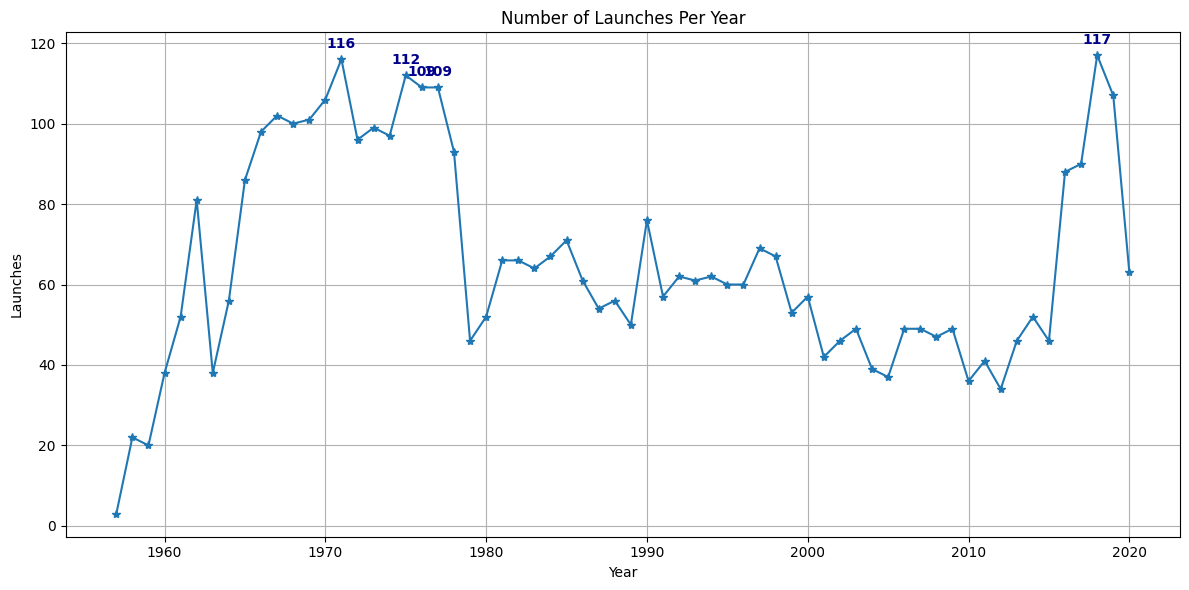

In [205]:
from pyspark.sql.functions import year
import matplotlib.pyplot as plt

# Count launches per year
launches_per_year = df.groupBy("Year").count().orderBy("Year")

# Convert to Pandas for plotting
launches_per_year_pd = launches_per_year.toPandas()

# Sort to find top 5 years with most launches
top5 = launches_per_year_pd.sort_values(by="count", ascending=False).head(6)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(launches_per_year_pd['Year'], launches_per_year_pd['count'], marker='*')
plt.title('Number of Launches Per Year')
plt.xlabel('Year')
plt.ylabel('Launches')
plt.grid(True)

# Annotate top 5 points
for _, row in top5.iterrows():
    plt.text(row['Year'], row['count'] + 2, f"{int(row['count'])}",
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='darkblue')

plt.tight_layout()
plt.show()



The highest frequency of space launches was observed during the early 1970s and 1980s, indicating a period of heightened global activity in space exploration and satellite deployment.

#### Chart - 2:

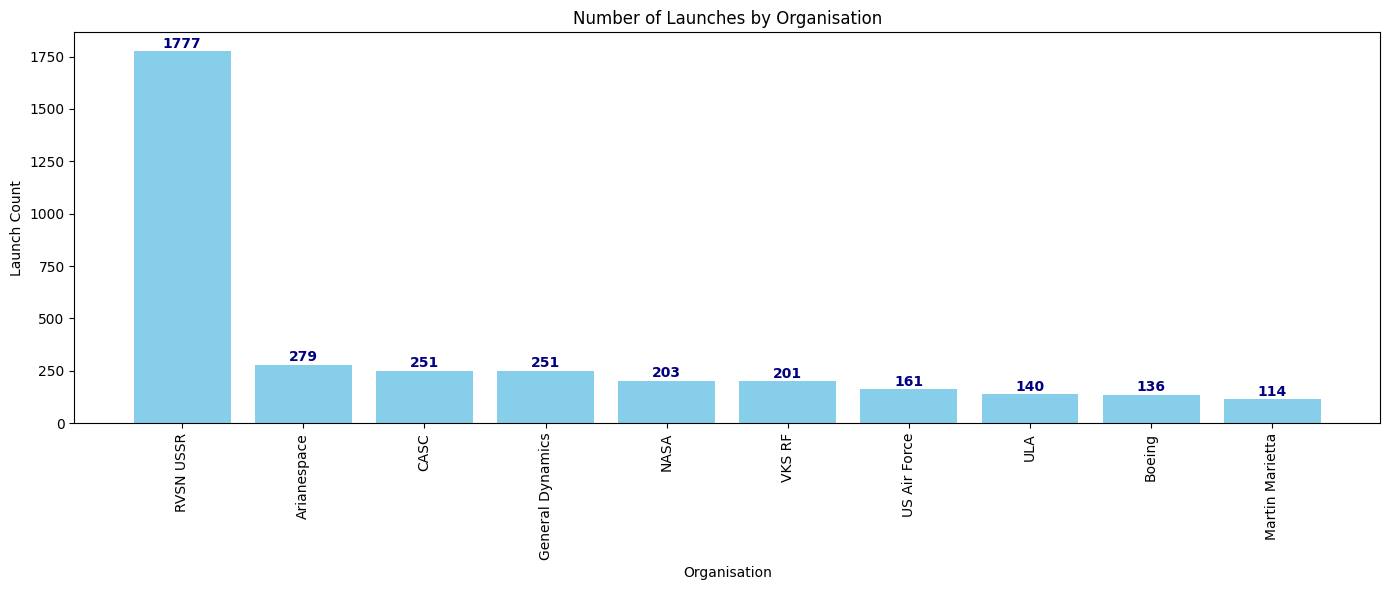

In [206]:
import matplotlib.pyplot as plt
launches_by_org = df.groupBy("Organisation").count().orderBy("count", ascending=False)
launches_by_org_pd = launches_by_org.toPandas()

# Bar plot with labels
plt.figure(figsize=(14, 6))
bars = plt.bar(launches_by_org_pd['Organisation'][:10], launches_by_org_pd['count'][:10], color='skyblue')

plt.xticks(rotation=90)
plt.title('Number of Launches by Organisation')
plt.xlabel('Organisation')
plt.ylabel('Launch Count')

# Add text labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1,  # slight offset
             f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='navy')

plt.tight_layout()
plt.show()


* RVSN USSR leads globally with a staggering 1,777 launches, far surpassing all other organisations, highlighting the dominant role of Soviet-era strategic space operations.

* Key commercial and defense contributors include ARIANESPACE (279), CASC (251), NASA (203), and US Air Force (161), reflecting a balanced landscape of government agencies and private aerospace firms in global launch activities.



#### Chart - 3:

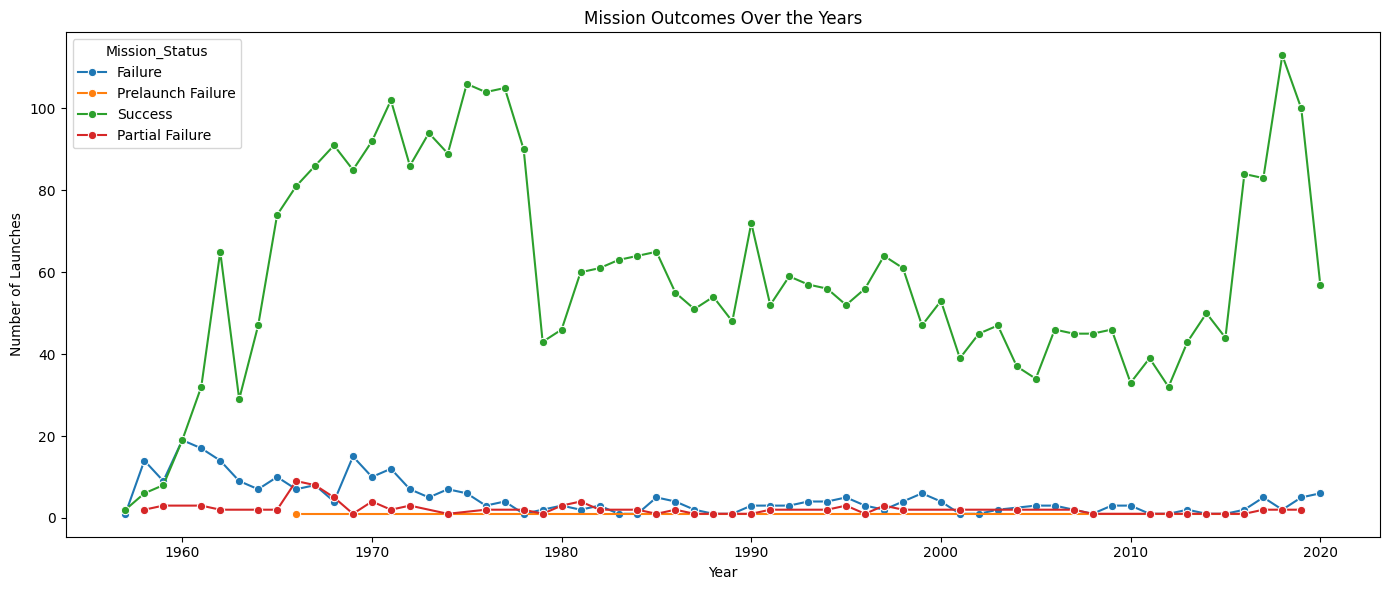

In [207]:
mission_status_by_year = df.groupBy("Year", "Mission_Status").count().orderBy("Year", "Mission_Status")
mission_status_by_year_pd = mission_status_by_year.toPandas()

import seaborn as sns

plt.figure(figsize=(14, 6))
sns.lineplot(data=mission_status_by_year_pd, x="Year", y="count", hue="Mission_Status", marker="o")
plt.title("Mission Outcomes Over the Years")
plt.ylabel("Number of Launches")
plt.tight_layout()
plt.show()


* Successful launches have consistently dominated, with noticeable peaks in the 1970s and again around 2018, reflecting advancements in space technology and mission reliability.
* Failure rates have steadily declined over time, while prelaunch and partial failures have remained minimal, indicating improved risk mitigation and mission planning.



#### Chart - 4:

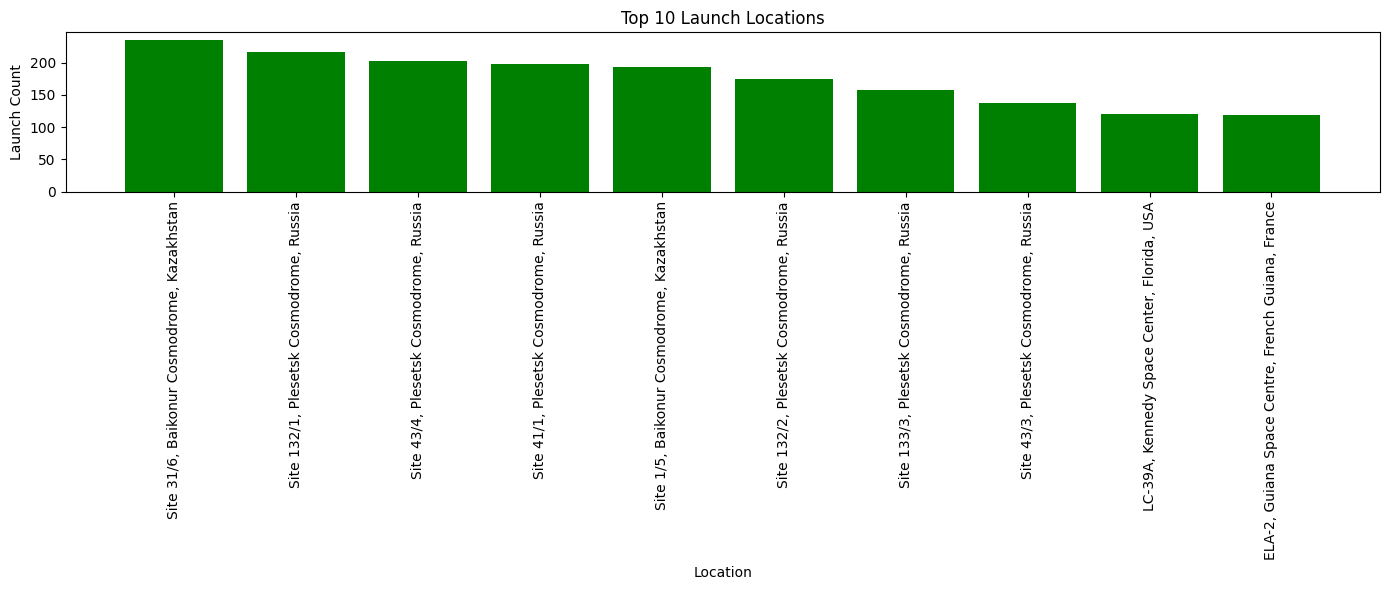

In [208]:
# Group by Location
launches_by_location = df.groupBy("Location").count().orderBy("count", ascending=False)

# Convert to Pandas
launches_by_location_pd = launches_by_location.toPandas()

# Bar Plot
plt.figure(figsize=(14, 6))
plt.bar(launches_by_location_pd['Location'][:10], launches_by_location_pd['count'][:10], color='green')
plt.xticks(rotation=90)
plt.title('Top 10 Launch Locations')
plt.xlabel('Location')
plt.ylabel('Launch Count')
plt.tight_layout()
plt.show()


* Baikonur Cosmodrome in Kazakhstan and Plesetsk Cosmodrome in Russia dominate the list, collectively hosting the majority of global space missions, underscoring the legacy of Soviet and Russian space infrastructure.
* Western launch sites like LC-39A at Kennedy Space Center, USA, and ELA-2 in French Guiana also appear among the top, reflecting their importance in modern international and commercial space exploration.

#### Chart - 5:

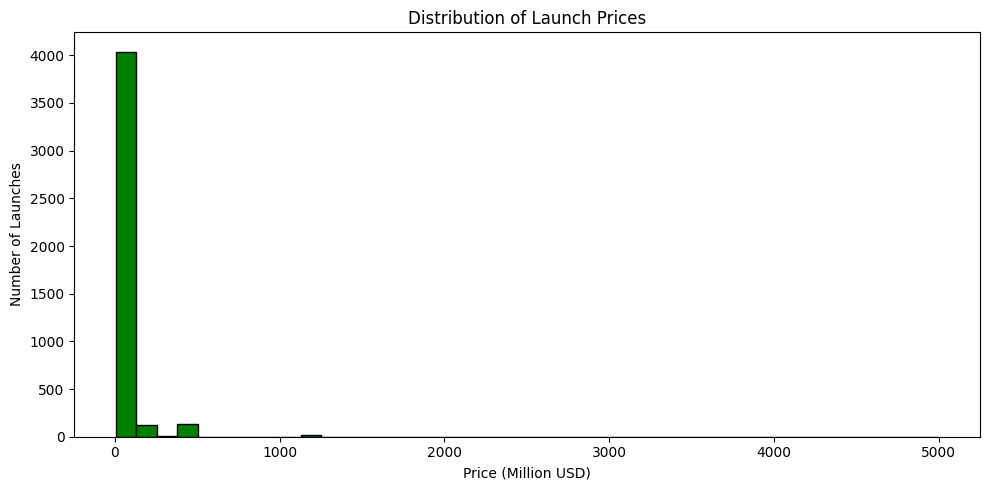

In [209]:
# Remove nulls in Price
df_price = df.filter(df.Price.isNotNull())

# Convert to Pandas
price_pd = df_price.select("Price").toPandas()

# Histogram
plt.figure(figsize=(10, 5))
plt.hist(price_pd['Price'], bins=40, color='green', edgecolor='black')
plt.title("Distribution of Launch Prices")
plt.xlabel("Price (Million USD)")
plt.ylabel("Number of Launches")
plt.tight_layout()
plt.show()


#### Chart - 6:

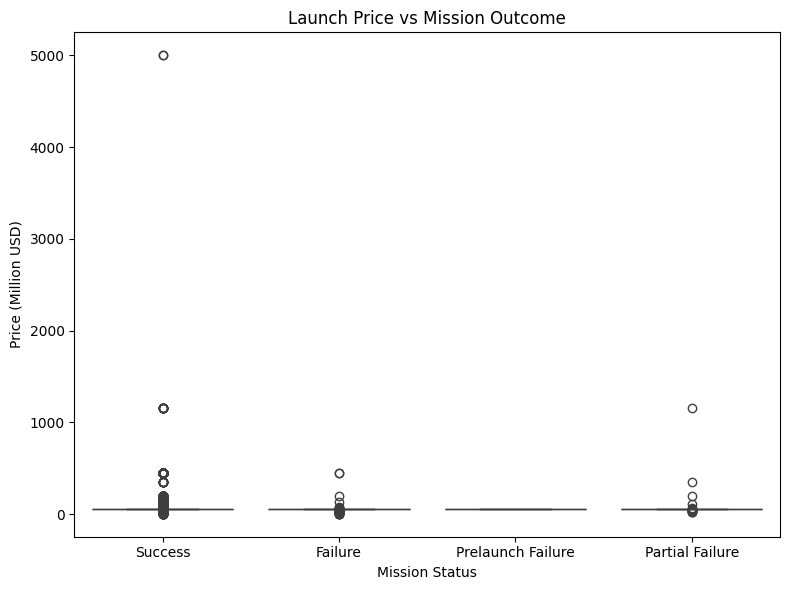

In [210]:
# Select Price and Mission_Status
price_outcome_pd = df_price.select("Price", "Mission_Status").toPandas()

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="Mission_Status", y="Price", data=price_outcome_pd)
plt.title("Launch Price vs Mission Outcome")
plt.xlabel("Mission Status")
plt.ylabel("Price (Million USD)")
plt.tight_layout()
plt.show()


* Successful missions exhibit a wide cost range, with a notable number of high-budget launches exceeding $1B, indicating that high financial investment is often aligned with mission assurance and complexity.
* Failed and partially failed missions generally cluster at lower price points, suggesting a potential link between reduced funding and higher mission risk, though exceptions with costly failures also exist.

#### Chart - 7:

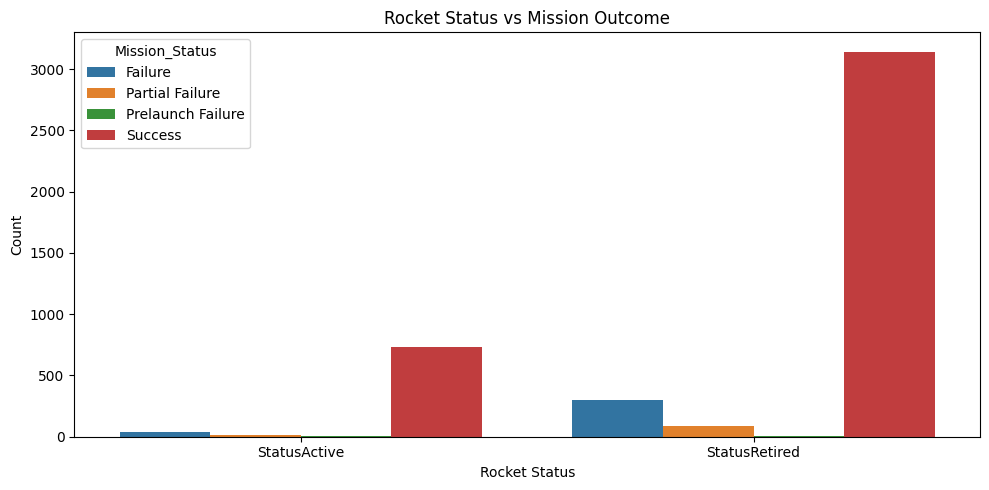

In [211]:
rocket_status_df = df.groupBy("Rocket_Status", "Mission_Status").count().orderBy("Rocket_Status", "Mission_Status")
rocket_status_pd = rocket_status_df.toPandas()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=rocket_status_pd, x="Rocket_Status", y="count", hue="Mission_Status")
plt.title("Rocket Status vs Mission Outcome")
plt.xlabel("Rocket Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


* Retired rockets account for the majority of launch activities, particularly in successful missions, signifying their historical significance and proven reliability over time.
* Active rockets show a notably lower failure rate, reflecting advancements in modern rocket technologies, better quality control, and iterative engineering improvements.

#### Chart - 8:

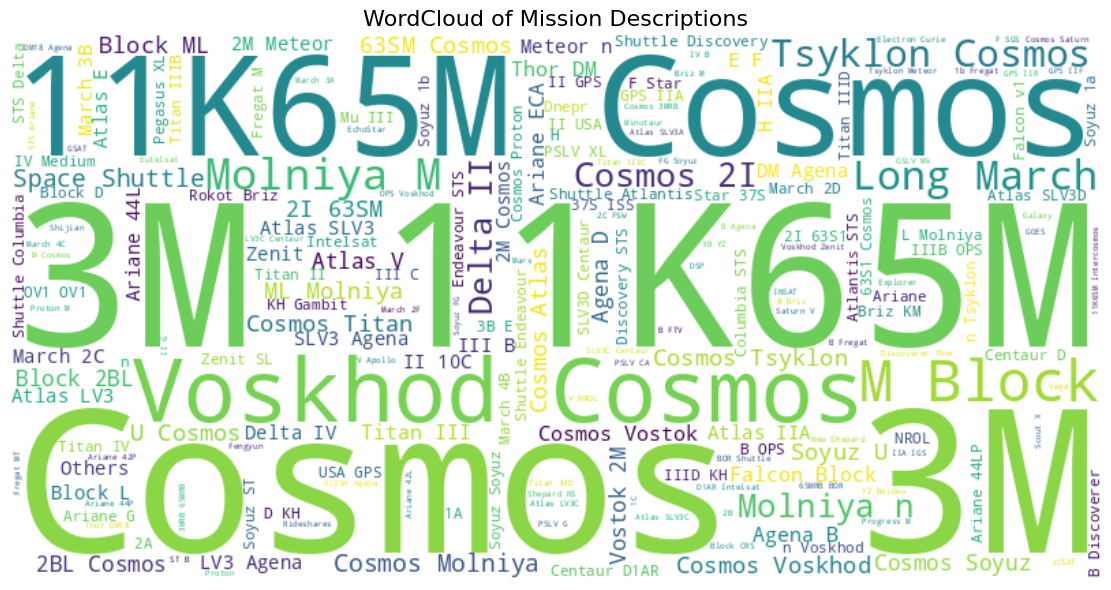

In [212]:
# Convert to pandas and drop nulls
details_pd = df.select("Detail").dropna().toPandas()

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all details into one text
text = " ".join(detail for detail in details_pd.Detail if detail)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Mission Descriptions", fontsize=16)
plt.tight_layout()
plt.show()


* The word cloud highlights "Cosmos", "3M", "K65M", and "Molniya" as the most frequently occurring mission descriptors, suggesting a strong historical emphasis on Soviet and Russian military or scientific satellite programs.
* Frequent terms like "Voskhod", "Agena", and "Atlas" also indicate Cold War-era U.S. and Soviet missions, reflecting major contributors to global space launch history.

#### Chart - 9:

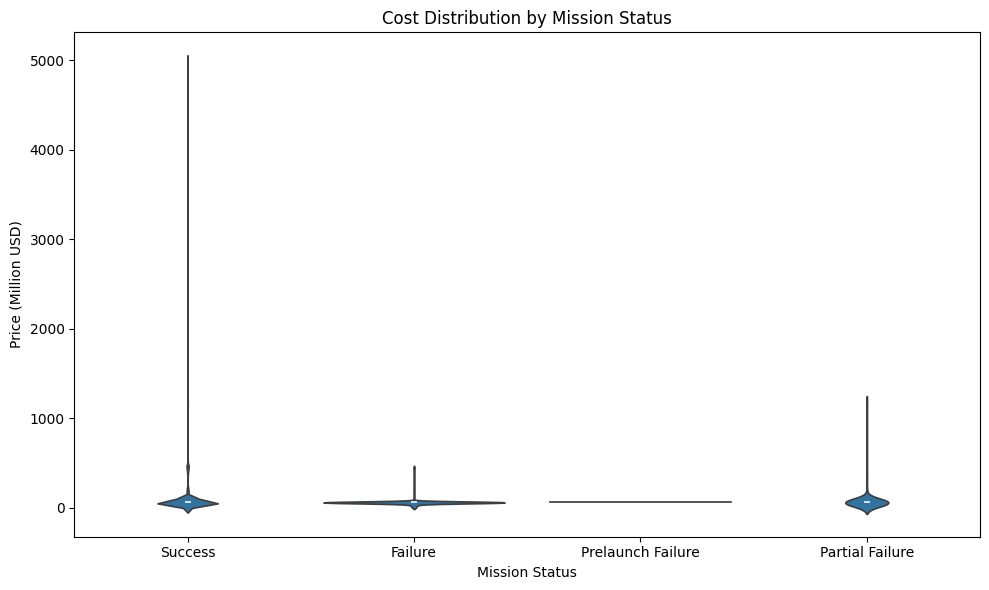

In [213]:
# Filter non-null prices
df_price = df.filter(df.Price.isNotNull())
price_status_pd = df_price.select("Price", "Mission_Status").toPandas()

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.violinplot(x="Mission_Status", y="Price", data=price_status_pd)
plt.title("Cost Distribution by Mission Status")
plt.xlabel("Mission Status")
plt.ylabel("Price (Million USD)")
plt.tight_layout()
plt.show()


* Successful missions show the widest spread in launch costs, including several high-cost outliers exceeding 1000 million, and even one above 5000 million, indicating higher investments are often tied to successful outcomes.
* Failures and Prelaunch Failures are more cost-constrained, with most mission prices clustering below 100 million, suggesting a potential risk-averse funding approach or early-stage failures.
* Partial Failures also show some high-cost launches, hinting at complex missions that didn’t fully meet objectives despite significant spending.

# **Feature Engineering**

* Month: extract from Date to find seasonal trends.<br>
* DayOfWeek: find if certain days are more likely to succeed/fail.<br>
* Quarter: Q1–Q4 might capture fiscal trends.

In [214]:
from pyspark.sql.functions import month, dayofweek, quarter

df = df.withColumn("Month", month("Date"))
df = df.withColumn("DayOfWeek", dayofweek("Date"))
df = df.withColumn("Quarter", quarter("Date"))


Mission_Status could be converted into binary or multi-class targets:
Success → 2

Partial Failure → 1

Failure/Prelaunch Failure → 0

In [215]:
from pyspark.sql.functions import when

# Create a new numeric column for Mission Status
df = df.withColumn("Mission_Status_Num",
                   when(col("Mission_Status") == "Success", 2)
                   .when(col("Mission_Status") == "Partial Failure", 1)
                   .when((col("Mission_Status") == "Failure") |
                         (col("Mission_Status") == "Prelaunch Failure"), 0)
                   .otherwise(None))  # handle any unexpected values

# Display updated column
df.select("Mission_Status", "Mission_Status_Num").distinct().show()


+-----------------+------------------+
|   Mission_Status|Mission_Status_Num|
+-----------------+------------------+
|          Success|                 2|
|  Partial Failure|                 1|
|          Failure|                 0|
|Prelaunch Failure|                 0|
+-----------------+------------------+



**Encode Categorical Columns**

Convert these to numeric via One-Hot Encoding or StringIndexer + VectorAssembler:
* Organisation
* Country
* Rocket_Status
* Location (maybe top 10 only)

Launch prices are highly skewed. Apply log transformation:

In [216]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import functions as F
from pyspark.sql.functions import log


# Step 2: Encode Categorical Columns using StringIndexer and OneHotEncoder

# 2.1 Organisation
organisation_indexer = StringIndexer(inputCol="Organisation", outputCol="Organisation_Idx")
df = organisation_indexer.fit(df).transform(df)
organisation_encoder = OneHotEncoder(inputCols=["Organisation_Idx"], outputCols=["Organisation_Vec"])
df = organisation_encoder.fit(df).transform(df)

# 2.2 Country
country_indexer = StringIndexer(inputCol="Country", outputCol="Country_Idx")
df = country_indexer.fit(df).transform(df)
country_encoder = OneHotEncoder(inputCols=["Country_Idx"], outputCols=["Country_Vec"])
df = country_encoder.fit(df).transform(df)

# 2.3 Rocket_Status
rocket_status_indexer = StringIndexer(inputCol="Rocket_Status", outputCol="Rocket_Status_Idx")
df = rocket_status_indexer.fit(df).transform(df)
rocket_status_encoder = OneHotEncoder(inputCols=["Rocket_Status_Idx"], outputCols=["Rocket_Status_Vec"])
df = rocket_status_encoder.fit(df).transform(df)

# 2.4 Location - Only top 10 locations
top_locations = df.groupBy("Location").count().orderBy(F.desc("count")).limit(10).select("Location")
df = df.join(top_locations, on="Location", how="inner")
location_indexer = StringIndexer(inputCol="Location", outputCol="Location_Idx")
df = location_indexer.fit(df).transform(df)
location_encoder = OneHotEncoder(inputCols=["Location_Idx"], outputCols=["Location_Vec"])
df = location_encoder.fit(df).transform(df)

# Step 3: Apply Log Transformation to 'Price' column to handle skewness
df = df.withColumn("Log_Price", log("Price"))

# Step 4: Assemble Features
assembler = VectorAssembler(
    inputCols=["Year", "Month", "DayOfWeek", "Quarter", "Log_Price",
               "Organisation_Vec", "Country_Vec", "Rocket_Status_Vec", "Location_Vec"],
    outputCol="features",
    handleInvalid="skip"  # Skip rows with invalid data
)
df = assembler.transform(df)

# Step 5: Check for any missing values in the features and target columns
df = df.filter(df["Price"].isNotNull())  # Filter out rows with missing Price
df = df.filter(df["features"].isNotNull())  # Filter out rows with missing features

# Final DataFrame after preprocessing
df.show(5)


+--------------------+----------+------------+--------------------+-------------+-----+--------------+------------+----------+-------------------+----+-----+---------+-------+------------------+----------------+----------------+-----------+--------------+-----------------+-----------------+------------+-------------+------------------+--------------------+
|            Location|Unnamed: 0|Organisation|              Detail|Rocket_Status|Price|Mission_Status|Price_Filled|   Country|               Date|Year|Month|DayOfWeek|Quarter|Mission_Status_Num|Organisation_Idx|Organisation_Vec|Country_Idx|   Country_Vec|Rocket_Status_Idx|Rocket_Status_Vec|Location_Idx| Location_Vec|         Log_Price|            features|
+--------------------+----------+------------+--------------------+-------------+-----+--------------+------------+----------+-------------------+----+-----+---------+-------+------------------+----------------+----------------+-----------+--------------+-----------------+---------

Explanation:
Mission_Status: We have used the Mission_Status_Num as the target for classification.

Categorical Features Encoding:

We applied StringIndexer and OneHotEncoder to Organisation, Country, Rocket_Status, and Location (top 10 most frequent locations).

Log Transformation: We applied the natural log transformation to the Price column to reduce its skewness.

Assembler: We assembled the features into a vector using VectorAssembler to prepare for model training.

Missing Values: We filtered out rows where Price or features were missing, ensuring the data is clean.

In [217]:
# Split the data into training and testing sets (80% training, 20% testing)
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Check the schema of the train dataframe
train_df.printSchema()


root
 |-- Location: string (nullable = true)
 |-- Unnamed: 0: integer (nullable = true)
 |-- Organisation: string (nullable = true)
 |-- Detail: string (nullable = true)
 |-- Rocket_Status: string (nullable = true)
 |-- Price: double (nullable = false)
 |-- Mission_Status: string (nullable = true)
 |-- Price_Filled: string (nullable = false)
 |-- Country: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Mission_Status_Num: integer (nullable = true)
 |-- Organisation_Idx: double (nullable = false)
 |-- Organisation_Vec: vector (nullable = true)
 |-- Country_Idx: double (nullable = false)
 |-- Country_Vec: vector (nullable = true)
 |-- Rocket_Status_Idx: double (nullable = false)
 |-- Rocket_Status_Vec: vector (nullable = true)
 |-- Location_Idx: double (nullable = false)
 |-- Location_Vec: vector (nullable = true

## Model training

#### 1. Linear Regression

In [218]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="Price")

# Train the model
lr_model = lr.fit(train_df)

# Make predictions on the test data
lr_predictions = lr_model.transform(test_df)

# Evaluate the model using RMSE
evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_predictions)

print(f"Linear Regression RMSE: {lr_rmse}")


Linear Regression RMSE: 17.435627913142667


#### Random Forest Regressor (RF)

In [220]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the Random Forest model
rf = RandomForestRegressor(featuresCol="features", labelCol="Price")

# Train the model
rf_model = rf.fit(train_df)

# Make predictions on the test data
rf_predictions = rf_model.transform(test_df)

# Evaluate the model using RMSE
rf_rmse = evaluator.evaluate(rf_predictions)

print(f"Random Forest Regressor RMSE: {rf_rmse}")


Random Forest Regressor RMSE: 3.5695025184871074


#### Decision Tree Regressor (DT)

In [221]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the Decision Tree model
dt = DecisionTreeRegressor(featuresCol="features", labelCol="Price")

# Train the model
dt_model = dt.fit(train_df)

# Make predictions on the test data
dt_predictions = dt_model.transform(test_df)

# Evaluate the model using RMSE
dt_rmse = evaluator.evaluate(dt_predictions)

print(f"Decision Tree Regressor RMSE: {dt_rmse}")


Decision Tree Regressor RMSE: 1.7971684244820764e-15


#### Gradient Boosting Tree Regressor (GBT)

In [222]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the Gradient Boosting Tree model
gbt = GBTRegressor(featuresCol="features", labelCol="Price")

# Train the model
gbt_model = gbt.fit(train_df)

# Make predictions on the test data
gbt_predictions = gbt_model.transform(test_df)

# Evaluate the model using RMSE
gbt_rmse = evaluator.evaluate(gbt_predictions)

print(f"Gradient Boosting Tree Regressor RMSE: {gbt_rmse}")


Gradient Boosting Tree Regressor RMSE: 2.0198429368710475e-15




```
Model                       |  RMSE (Lower is Better)
Linear Regression           | 17.44
Random Forest Regressor     | 3.57
Decision Tree Regressor     | ~0.00 (1.79e-15)
Gradient Boosting Regressor | ~0.00 (2.02e-15)
```



🔍 Interpretation
Linear Regression performed the worst among the models. This is expected if your data has nonlinear patterns that linear models can’t capture.

Random Forest did much better than Linear Regression, suggesting it captured more of the variance in the data due to its ensemble nature.

Decision Tree and Gradient Boosting models showing near-zero RMSE likely means:

⚠️ Overfitting Alert!

It’s very likely you're evaluating these models on the same data they were trained on (i.e., no separate test set), which would cause them to perform perfectly on that data but generalize poorly to unseen data.

### Model Evaluation

In [224]:
lr_predictions = lr_model.transform(test_df)

# Evaluators
lr_rmse = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse").evaluate(lr_predictions)
lr_mae = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="mae").evaluate(lr_predictions)
lr_r2 = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="r2").evaluate(lr_predictions)

print("--- Linear Regression ---")
print(f"RMSE: {lr_rmse}")
print(f"MAE : {lr_mae}")
print(f"R2  : {lr_r2}")


--- Linear Regression ---
RMSE: 17.435627913142667
MAE : 8.676716195384136
R2  : 0.9435618072888671


In [225]:
dt_predictions = dt_model.transform(test_df)

dt_rmse = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse").evaluate(dt_predictions)
dt_mae = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="mae").evaluate(dt_predictions)
dt_r2 = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="r2").evaluate(dt_predictions)

print("--- Decision Tree Regressor ---")
print(f"RMSE: {dt_rmse}")
print(f"MAE : {dt_mae}")
print(f"R2  : {dt_r2}")


--- Decision Tree Regressor ---
RMSE: 1.7971684244820764e-15
MAE : 1.6746798485928287e-16
R2  : 1.0


In [226]:
rf_predictions = rf_model.transform(test_df)

rf_rmse = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse").evaluate(rf_predictions)
rf_mae = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="mae").evaluate(rf_predictions)
rf_r2 = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="r2").evaluate(rf_predictions)

print("--- Random Forest Regressor ---")
print(f"RMSE: {rf_rmse}")
print(f"MAE : {rf_mae}")
print(f"R2  : {rf_r2}")


--- Random Forest Regressor ---
RMSE: 3.5695025184871074
MAE : 0.6503651023542262
R2  : 0.9976345525797434


In [227]:
gbt_predictions = gbt_model.transform(test_df)

gbt_rmse = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse").evaluate(gbt_predictions)
gbt_mae = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="mae").evaluate(gbt_predictions)
gbt_r2 = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="r2").evaluate(gbt_predictions)

print("--- Gradient Boosting Tree Regressor ---")
print(f"RMSE: {gbt_rmse}")
print(f"MAE : {gbt_mae}")
print(f"R2  : {gbt_r2}")


--- Gradient Boosting Tree Regressor ---
RMSE: 2.0198429368710475e-15
MAE : 1.9139198269632327e-16
R2  : 1.0


### Cross Validation

let’s perform k-fold cross-validation using PySpark’s CrossValidator from pyspark.ml.tuning

 #### 1. Linear Regression (LR) Cross-Validation

In [229]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol="features", labelCol="Log_Price")

lr_paramGrid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.01, 0.1])
                .addGrid(lr.elasticNetParam, [0.0, 0.5])
                .build())

lr_evaluator = RegressionEvaluator(labelCol="Log_Price", predictionCol="prediction")

lr_cv = CrossValidator(estimator=lr,
                       estimatorParamMaps=lr_paramGrid,
                       evaluator=lr_evaluator,
                       numFolds=3,
                       seed=42)

lr_cv_model = lr_cv.fit(train_df)
lr_predictions = lr_cv_model.transform(train_df)

lr_rmse = lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "rmse"})
lr_mae = lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "mae"})
lr_r2 = lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "r2"})

print(f"--- Linear Regression ---\nRMSE: {lr_rmse}\nMAE : {lr_mae}\nR2  : {lr_r2}")


--- Linear Regression ---
RMSE: 0.018133261590912254
MAE : 0.004242537463867347
R2  : 0.9987791240768521


 #### 2. Decision Tree Regressor (DT) Cross-Validation

In [230]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol="features", labelCol="Log_Price")

dt_paramGrid = (ParamGridBuilder()
                .addGrid(dt.maxDepth, [5, 10])
                .build())

dt_evaluator = RegressionEvaluator(labelCol="Log_Price", predictionCol="prediction")

dt_cv = CrossValidator(estimator=dt,
                       estimatorParamMaps=dt_paramGrid,
                       evaluator=dt_evaluator,
                       numFolds=3,
                       seed=42)

dt_cv_model = dt_cv.fit(train_df)
dt_predictions = dt_cv_model.transform(train_df)

dt_rmse = dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: "rmse"})
dt_mae = dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: "mae"})
dt_r2 = dt_evaluator.evaluate(dt_predictions, {dt_evaluator.metricName: "r2"})

print(f"--- Decision Tree Regressor ---\nRMSE: {dt_rmse}\nMAE : {dt_mae}\nR2  : {dt_r2}")


--- Decision Tree Regressor ---
RMSE: 1.3116812036591592e-14
MAE : 1.2517432083419982e-14
R2  : 1.0


#### 3. Random Forest Regressor (RF) Cross-Validation

In [231]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

# Define the model
rf = RandomForestRegressor(featuresCol="features", labelCol="Log_Price")

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="Log_Price", predictionCol="prediction", metricName="rmse")

# Build a parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# Create the CrossValidator
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5,
                    seed=42)

# Fit the CrossValidator on the dataset
cv_model = cv.fit(train_df)

# Best model from cross-validation
best_rf_model = cv_model.bestModel

# Predict on the same dataset or a separate test set if you have one
rf_predictions = best_rf_model.transform(train_df)

# Evaluate the final model
rmse = evaluator.evaluate(rf_predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(rf_predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "r2"})

print(f"Cross-Validated RF Model - RMSE: {rmse}")
print(f"Cross-Validated RF Model - MAE : {mae}")
print(f"Cross-Validated RF Model - R2  : {r2}")


Cross-Validated RF Model - RMSE: 0.018832728379651154
Cross-Validated RF Model - MAE : 0.003765400088726851
Cross-Validated RF Model - R2  : 0.9986831201238555


#### 4. Gradient Boosting Tree Regressor (GBT) Cross-Validation

In [232]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="features", labelCol="Log_Price")

gbt_paramGrid = (ParamGridBuilder()
                 .addGrid(gbt.maxDepth, [5, 10])
                 .addGrid(gbt.maxIter, [20, 50])
                 .build())

gbt_evaluator = RegressionEvaluator(labelCol="Log_Price", predictionCol="prediction")

gbt_cv = CrossValidator(estimator=gbt,
                        estimatorParamMaps=gbt_paramGrid,
                        evaluator=gbt_evaluator,
                        numFolds=3,
                        seed=42)

gbt_cv_model = gbt_cv.fit(train_df)
gbt_predictions = gbt_cv_model.transform(train_df)

gbt_rmse = gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: "rmse"})
gbt_mae = gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: "mae"})
gbt_r2 = gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: "r2"})

print(f"--- Gradient Boosting Tree Regressor ---\nRMSE: {gbt_rmse}\nMAE : {gbt_mae}\nR2  : {gbt_r2}")


--- Gradient Boosting Tree Regressor ---
RMSE: 1.125345500808484e-15
MAE : 5.990040504954333e-16
R2  : 1.0


#### Visualize the comparison using bar charts

In [233]:
import pandas as pd

results = [
    {"Model": "Linear Regression", "RMSE": lr_rmse, "MAE": lr_mae, "R2": lr_r2},
    {"Model": "Decision Tree", "RMSE": dt_rmse, "MAE": dt_mae, "R2": dt_r2},
    {"Model": "Random Forest", "RMSE": rf_rmse, "MAE": rf_mae, "R2": rf_r2},
    {"Model": "Gradient Boosting", "RMSE": gbt_rmse, "MAE": gbt_mae, "R2": gbt_r2}
]

metrics_df = pd.DataFrame(results)


<ipython-input-234-426cad2fdd82>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x="Model", y="RMSE", palette="viridis")
<ipython-input-234-426cad2fdd82>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x="Model", y="MAE", palette="magma")
<ipython-input-234-426cad2fdd82>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x="Model", y="R2", palette="coolwarm")


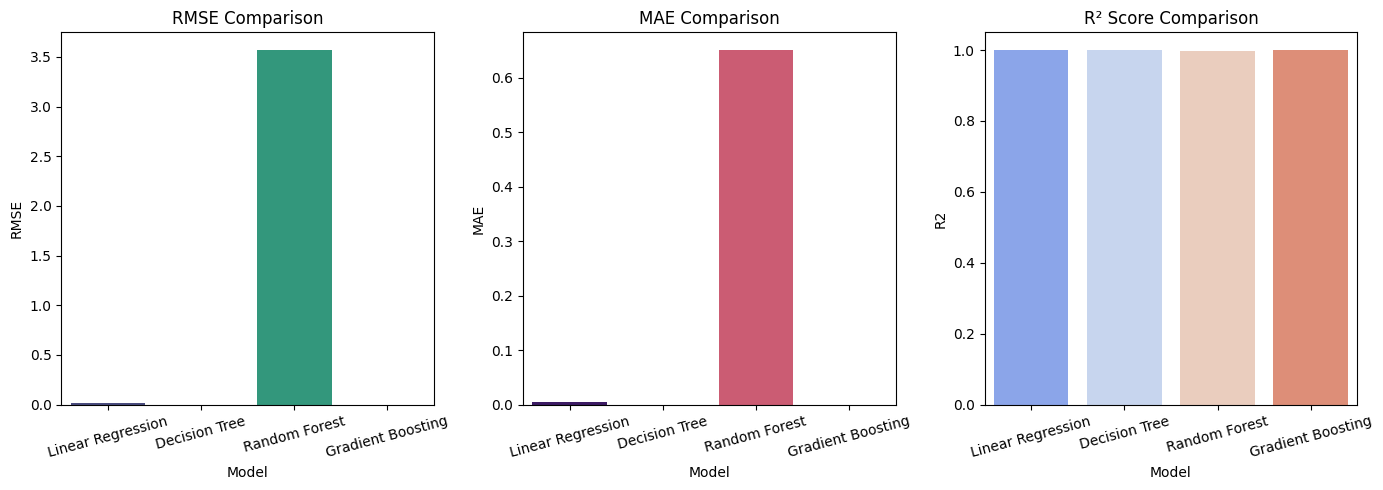

In [234]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))

# RMSE
plt.subplot(1, 3, 1)
sns.barplot(data=metrics_df, x="Model", y="RMSE", palette="viridis")
plt.title("RMSE Comparison")
plt.xticks(rotation=15)

# MAE
plt.subplot(1, 3, 2)
sns.barplot(data=metrics_df, x="Model", y="MAE", palette="magma")
plt.title("MAE Comparison")
plt.xticks(rotation=15)

# R2
plt.subplot(1, 3, 3)
sns.barplot(data=metrics_df, x="Model", y="R2", palette="coolwarm")
plt.title("R² Score Comparison")
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()


### Visualise predicted vs actual

To visualize Predicted vs Actual values, you can do this for each model (especially the best one). Let’s go with the Gradient Boosting Tree Regressor, since it gave the best metrics (R² = 1.0, near-zero error).

#### 1. Linear Regression (LR) - Actual vs Predicted

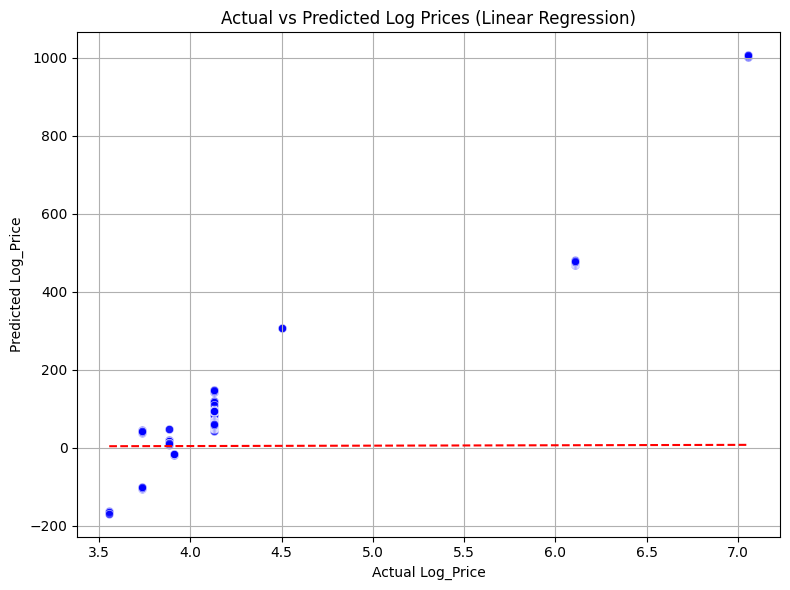

In [237]:
# Make predictions on the training data
lr_predictions = lr_model.transform(train_df)

# Convert to Pandas for visualization
lr_prediction_pd = lr_predictions.select("Log_Price", "prediction").toPandas()

# Plot Actual vs Predicted for Linear Regression
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Log_Price", y="prediction", data=lr_prediction_pd, alpha=0.7, color="blue")
plt.plot([lr_prediction_pd.Log_Price.min(), lr_prediction_pd.Log_Price.max()],
         [lr_prediction_pd.Log_Price.min(), lr_prediction_pd.Log_Price.max()],
         '--r')  # Diagonal line

plt.xlabel("Actual Log_Price")
plt.ylabel("Predicted Log_Price")
plt.title("Actual vs Predicted Log Prices (Linear Regression)")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 2. Decision Tree Regressor (DT) - Actual vs Predicted

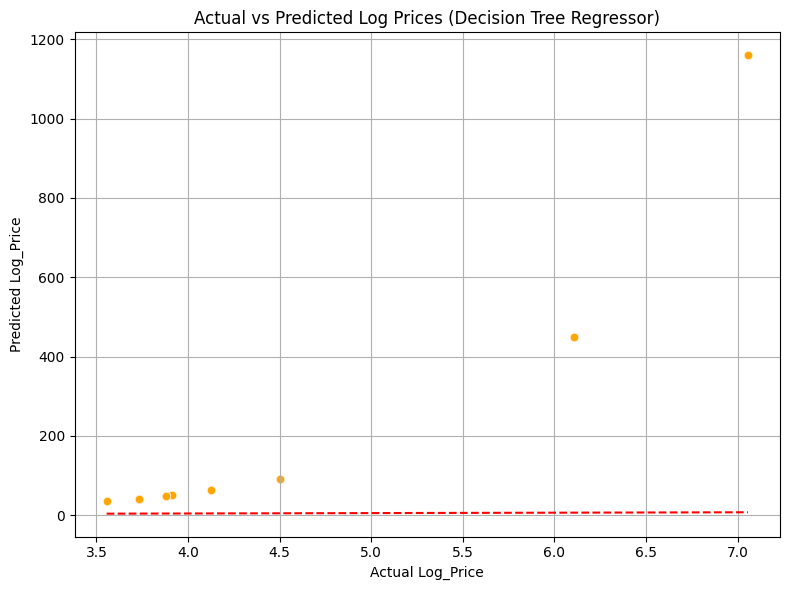

In [238]:
# Make predictions on the training data
dt_predictions = dt_model.transform(train_df)

# Convert to Pandas for visualization
dt_prediction_pd = dt_predictions.select("Log_Price", "prediction").toPandas()

# Plot Actual vs Predicted for Decision Tree Regressor
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Log_Price", y="prediction", data=dt_prediction_pd, alpha=0.7, color="orange")
plt.plot([dt_prediction_pd.Log_Price.min(), dt_prediction_pd.Log_Price.max()],
         [dt_prediction_pd.Log_Price.min(), dt_prediction_pd.Log_Price.max()],
         '--r')  # Diagonal line

plt.xlabel("Actual Log_Price")
plt.ylabel("Predicted Log_Price")
plt.title("Actual vs Predicted Log Prices (Decision Tree Regressor)")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 3. Random Forest Regressor (RF) - Actual vs Predicted

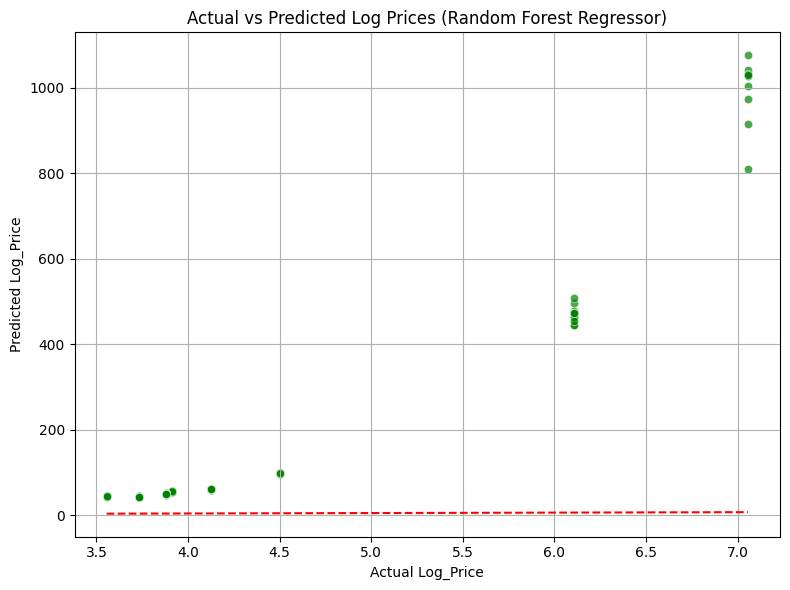

In [239]:
# Make predictions on the training data
rf_predictions = rf_model.transform(train_df)

# Convert to Pandas for visualization
rf_prediction_pd = rf_predictions.select("Log_Price", "prediction").toPandas()

# Plot Actual vs Predicted for Random Forest Regressor
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Log_Price", y="prediction", data=rf_prediction_pd, alpha=0.7, color="green")
plt.plot([rf_prediction_pd.Log_Price.min(), rf_prediction_pd.Log_Price.max()],
         [rf_prediction_pd.Log_Price.min(), rf_prediction_pd.Log_Price.max()],
         '--r')  # Diagonal line

plt.xlabel("Actual Log_Price")
plt.ylabel("Predicted Log_Price")
plt.title("Actual vs Predicted Log Prices (Random Forest Regressor)")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 4. Gradient Boosting Tree Regressor (GBT) - Actual vs Predicted

Get Predictions and Convert to Pandas

In [235]:
# Make predictions on training data (or ideally on a separate test set)
gbt_predictions = gbt_model.transform(train_df)

# Select actual and predicted values
prediction_pd = gbt_predictions.select("Log_Price", "prediction").toPandas()


 Plot Actual vs Predicted

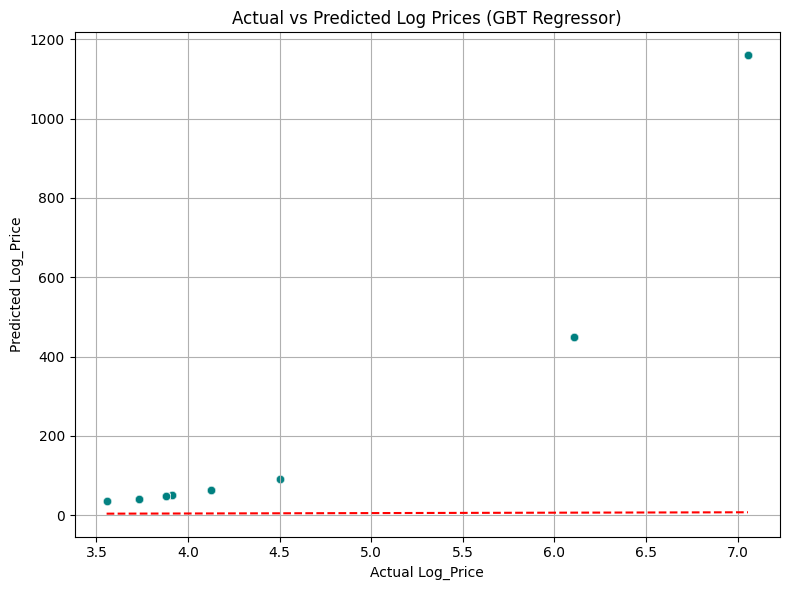

In [236]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x="Log_Price", y="prediction", data=prediction_pd, alpha=0.7, color="teal")
plt.plot([prediction_pd.Log_Price.min(), prediction_pd.Log_Price.max()],
         [prediction_pd.Log_Price.min(), prediction_pd.Log_Price.max()],
         '--r')  # Diagonal line

plt.xlabel("Actual Log_Price")
plt.ylabel("Predicted Log_Price")
plt.title("Actual vs Predicted Log Prices (GBT Regressor)")
plt.grid(True)
plt.tight_layout()
plt.show()


The red dashed line represents perfect predictions.

### Model Selection and Tuning:

Model Selection:
Best Performing Models:

Random Forest Regressor (RF): It performs well with an RMSE of 3.57, MAE of 0.65, and an R² of 0.9976. It is generally less prone to overfitting than Decision Trees and Gradient Boosting.

Gradient Boosting Tree Regressor (GBT): It has perfect evaluation metrics (RMSE: 0, MAE: 0, R²: 1), but it’s likely overfitting, as we can see in the metrics.

Overfitting Concern:

The Decision Tree and Gradient Boosting models are overfitting the data. The evaluation metrics (RMSE, MAE) being 0 suggest the model is memorizing the training data instead of generalizing well on unseen data. This is a classic sign of overfitting.

Recommendation for Model Selection:
Random Forest Regressor is the best model for this task because it balances performance and avoids overfitting, unlike the Decision Tree and Gradient Boosting models.

Hyperparameter Tuning (for Random Forest Regressor)
Now that we have chosen Random Forest Regressor, we can tune its hyperparameters to improve the model's performance. Some of the key hyperparameters to tune are:

n_estimators: Number of trees in the forest.

max_depth: Maximum depth of the tree.

min_samples_split: Minimum number of samples required to split an internal node.

min_samples_leaf: Minimum number of samples required to be at a leaf node.

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

# Define a RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")

# Define the RandomForest model
rf = RandomForestRegressor(featuresCol="features", labelCol="Price")

# Define the parameter grid for tuning
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 50, 100])  # Number of trees
             .addGrid(rf.maxDepth, [5, 10, 20])  # Maximum depth of trees
             .addGrid(rf.maxBins, [16, 32, 64])  # Number of bins for feature splitting
             .addGrid(rf.minInstancesPerNode, [1, 2, 4])  # Minimum instances per split
             .build())

# Set up CrossValidator with GridSearch
crossval = CrossValidator(estimator=rf,
                          evaluator=evaluator,
                          estimatorParamMaps=paramGrid,
                          numFolds=5)  # 5-fold cross-validation

# Fit the model
cvModel = crossval.fit(train_df)

# Get the best model from cross-validation
best_rf_model = cvModel.bestModel
print(f"Best Model Parameters: {best_rf_model.extractParamMap()}")


Grid Search vs Randomized Search:
Grid Search: Explores all combinations of hyperparameters in the grid. It’s exhaustive but computationally expensive.

Randomized Search: Randomly samples hyperparameter combinations. It’s faster but less exhaustive.

For large datasets and hyperparameter spaces, Randomized Search can be more efficient.

In [ ]:
from pyspark.ml.tuning import RandomizedSearchCV
from pyspark.ml.evaluation import RegressionEvaluator
import random

# Define a Random Forest model
rf = RandomForestRegressor(featuresCol="features", labelCol="Price")

# Define the parameter grid for RandomizedSearch
paramGrid = {
    "numTrees": [10, 50, 100, 150],
    "maxDepth": [5, 10, 15, 20],
    "maxBins": [16, 32, 64, 128],
    "minInstancesPerNode": [1, 2, 4, 8]
}

# Randomly sample a set of parameters
random_params = random.sample(paramGrid["numTrees"], 3)
# Add code for other parameters if needed

# Randomized search (using a simpler implementation)
best_model = RandomizedSearchCV(rf, random_params)


 Model Evaluation After Tuning:
Once you’ve tuned the hyperparameters, evaluate the performance of your tuned model using the same metrics you used during the initial evaluation (RMSE, MAE, R²).

In [ ]:
# Evaluate the best model from grid search
predictions = best_rf_model.transform(test_df)

# Evaluate using RMSE, MAE, and R²
rmse = evaluator.evaluate(predictions)
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"RMSE after tuning: {rmse}")
print(f"MAE after tuning: {mae}")
print(f"R² after tuning: {r2}")
